# Spectral noise regression
This notebook develops the method for iteratively regressing the "noise" (stochastic-like) component of the spectral representation. 

You specify a regression function form, e.g. 1/f, or Lorentzian (1/f with knee), and the regression is done by maximizing total data likelihood assuming exponentially distributed power coefficients at each frequency.

---
### More detailed description:

Having seen in the previous notebooks (derivation and metrics) that a portion of the frequency spectrum for neural data very closely follows the hypothesized exponential distribution for signal power (i.e., Fourier coefficients are distributed as 2D complex Gaussian, thus the power, or squared radius, is exponentially distributed). Therefore, we'd like to fit the "background" or "noise" spectrum by only considering those frequncies that follow the assumption well. However, even for frequencies where there are oscillations, it may operate between a bursting and noise state, meaning that the oscillation is sometimes there, thus boosting the power in that frequency, but otherwise still follows the noise distribution.

Thus, we don't want to discard frequencies altogether, which is what happens when fitting the average power spectrum while accounting for oscillatory frequencies. We'd like to use as much of the information as possible, including the time points in those frequencies that are in the noise-like state.

To do that, we perform a very simple regression by fitting the entire time-frequency representation to a background function, like the Lorentzian, while assuming that the residual is exponentially distributed at each frequency. It's very much like regular regression, which fits a linear function to data that is normally scattered. The goal is to fit the background function parameters (offset, knee, exponent) while maximizing likelihood (e.g., maximum likelihood). Critically, this procedure does not know anything about "oscillations" or Gaussian peaks, just that data is supposed to be exponentially distributed with the mean following the Lorentzian function.

The initial fits will be poor due to oscillations and other non-noise data points, but one can then compute the likelihood for each data point, and iteratively drop out those with very low likelihood given the current model. Those points are typically either oscillatory burst periods (with higher power) in an otherwise noise-like frequency, or a frequency that's essentially under constant oscillation and thus poorly described by the background function as a whole. So we drop X% of the data points with the lowest likelihood, and re-fit the remaining data iteratively.

---
Some to dos:
- collect fit at each step
- there something weird with likelihood being a function of lambda, which is frequency dependent. Ideally it'd be normalized

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import FigureCanvasPdf, PdfPages
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.spines.right']=False
plt.rcParams['image.cmap'] = 'inferno'
font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 12}
plt.rc('font', **font)


import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from neurodsp import sim, plts
import numpy as np
from numpy import log10
from scipy import random, signal, stats
from scipy.optimize import minimize
from scipy.stats import expon
from statsmodels.tsa.stattools import acf
from sklearn.decomposition import PCA

In [4]:
def lorentzian(f, A, k, exp):
    # background function form
    return A/(k+f**exp)

def exp_prob(xs, lambdas):
    # compute likelihood under exponential distribution given lambda (scale param)
    return lambdas*np.exp(-xs*lambdas)

def make_df(f_stft, power):
    # collect spectrogram and flatten into a single vector, with matching frequency axis
    # for easier management
    return pd.DataFrame(np.array([f_stft.repeat(power.shape[1]),power.flatten(), np.nan*np.ones(np.size(power))]).T, 
                        columns=['freq', 'power', 'lh'])

def compute_logL_flattened(params, data_f, data_p):
    # compute point-wise log likelihood for data
    A, k, exp = params
    lmb = 1/lorentzian(data_f, A, k, exp)
    return np.log10(exp_prob(data_p,lmb))

def total_neglogL(params, data_f, data_p):
    # return total negative log likelihood for optimization
    return -compute_logL_flattened(params, data_f, data_p).sum()

## same stuff but looping over frequencies
# def spectral_logL(params, data_f, data_p):
#     # compute log likelihood
#     A, k, exp = params
#     logL = []
#     for i_f, f in enumerate(data_f):
#         lmb = 1/lorentzian(f, A, k, exp)
#     #     lmb = 1/p.mean()
#         logL.append(np.log10(exp_prob(data_p[i_f],lmb)))
    
#     return np.array(logL)

# def total_neglogL(params, data_f, data_p):
#     return -np.array(spectral_logL(params, data_f, data_p)).sum()


# real data

In [10]:
from scipy import io
data = io.loadmat('/Users/rdgao/Documents/data/CRCNS/hc2/Raw/lfp_spiketimes_ec013.527.mat', squeeze_me=True)
fs = data['srate']
lfp = data['data'][20]
lfp = (lfp-lfp.mean())/np.std(lfp)

# compute STFT
f_stft, t_stft, stft = signal.stft(lfp[int(fs*30):-int(fs*30)], fs=fs, nperseg=int(fs), noverlap=0, boundary=None)
power = abs(stft)**2

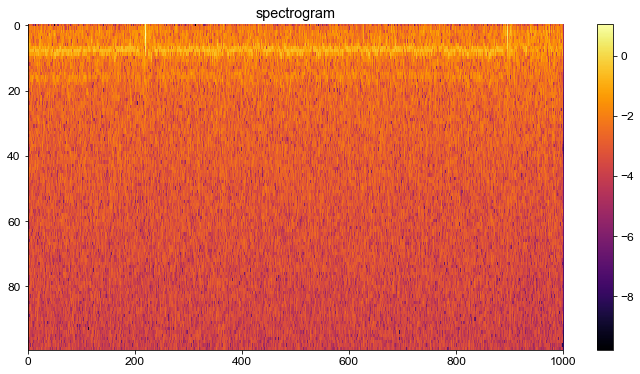

In [11]:
# plot spectrogram
plt.figure(figsize=(12,6))
# plt.imshow(-np.argsort(slogL, axis=0), aspect='auto')
# nll_rank = np.argsort(slogL, axis=None).reshape(slogL.shape)
# plt.imshow(nll_rank*(nll_rank>20000), aspect='auto')
plt.imshow(np.log10(power[:100,:]), aspect='auto')
plt.title('spectrogram')
plt.colorbar()

# iterative fit
1. fit Lorentzian assuming exponential distributed noise at every frequency, minimize total neg log likelihood
2. compute data likelihood for every square in the spectrogram given the fit model
3. drop the bottom n% of data with the lowest likelihood, back to step 1

In [12]:
# search params
npct = 0.5
x0 = (1, 20, 2)
bounds = [[0.01,100],[1,100000],[0,5]]

# compute spectrum
df_spg = make_df(f_stft[:200], power[:200,:])
psd = df_spg.groupby('freq').mean()['power']
psd_med = df_spg.groupby('freq').median()['power']

# subselect on freq bounds
df_select = df_spg[(df_spg['freq']>=1) & (df_spg['freq']<=200)]

99.50 percent data:
offset: 7.464, knee: 106.631, exponent: 2.254
mean trimmed logL: nan
---
99.00 percent data:
offset: 10.166, knee: 285.416, exponent: 2.323
mean trimmed logL: 2.986
---
98.51 percent data:
offset: 8.961, knee: 414.958, exponent: 2.296
mean trimmed logL: 3.007
---
98.01 percent data:
offset: 10.019, knee: 623.738, exponent: 2.320
mean trimmed logL: 3.025
---
97.52 percent data:
offset: 1.865, knee: 21.728, exponent: 1.960
mean trimmed logL: 3.040
---
97.04 percent data:
offset: 8.492, knee: 647.967, exponent: 2.288
mean trimmed logL: 3.040
---
96.55 percent data:
offset: 10.548, knee: 1022.660, exponent: 2.333
mean trimmed logL: 3.065
---
96.07 percent data:
offset: 12.593, knee: 1469.591, exponent: 2.369
mean trimmed logL: 3.078
---
95.59 percent data:
offset: 14.579, knee: 1978.871, exponent: 2.399
mean trimmed logL: 3.089
---
95.11 percent data:
offset: 16.283, knee: 2513.362, exponent: 2.422
mean trimmed logL: 3.100
---
94.63 percent data:
offset: 17.140, knee: 2

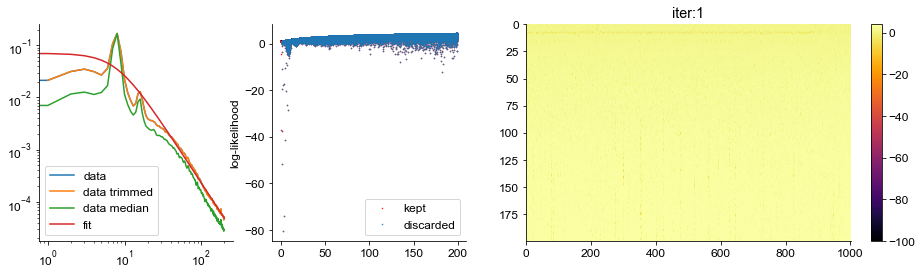

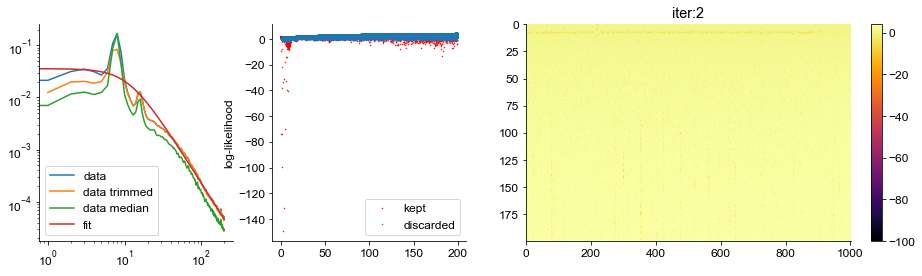

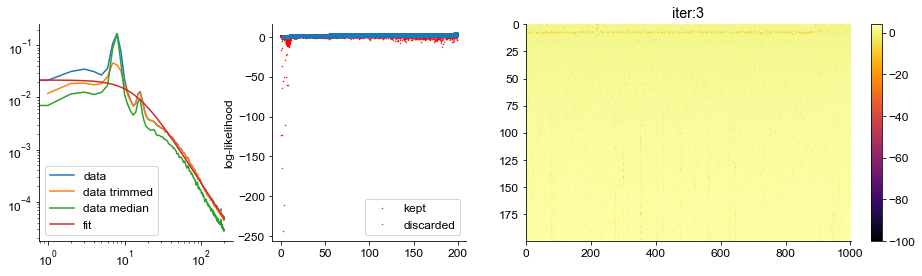

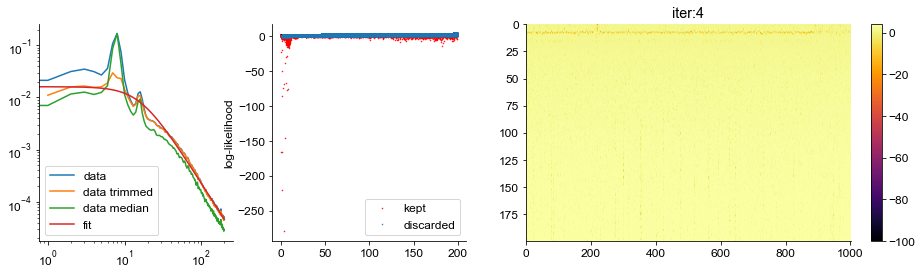

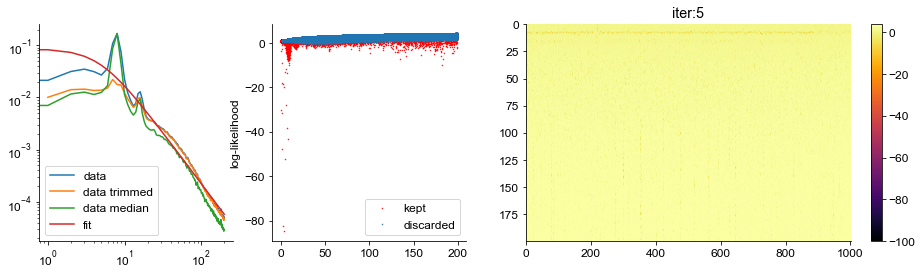

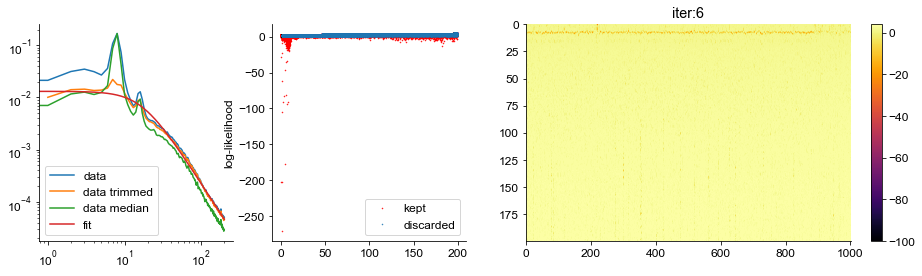

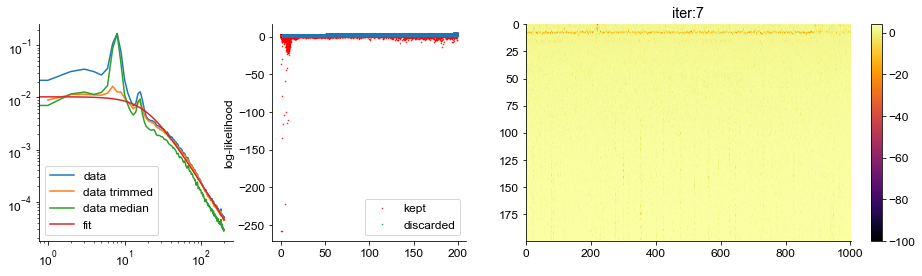

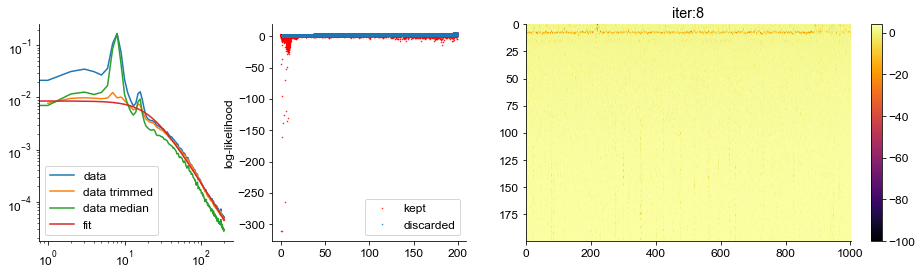

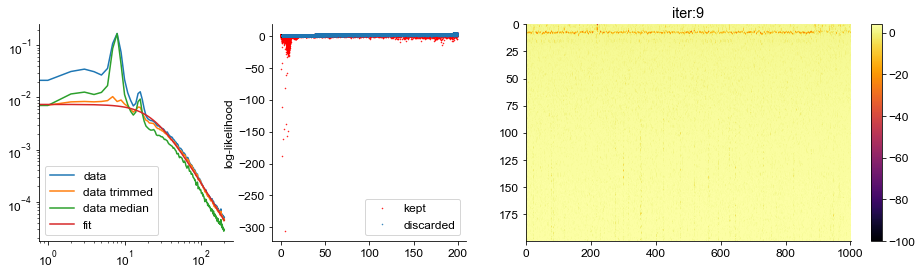

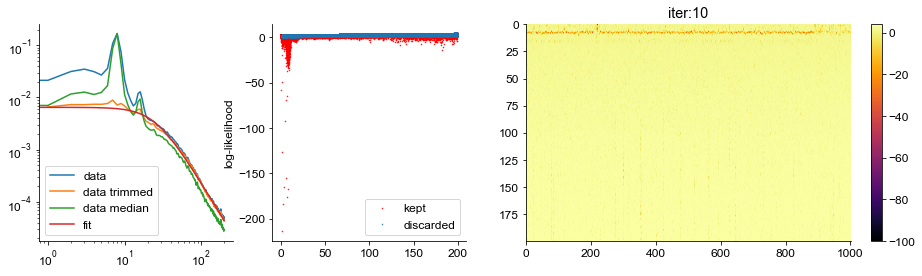

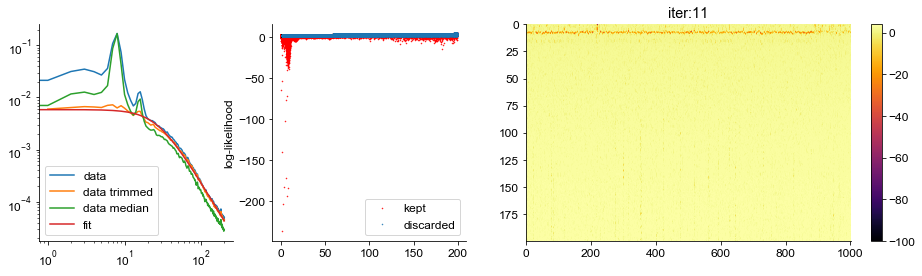

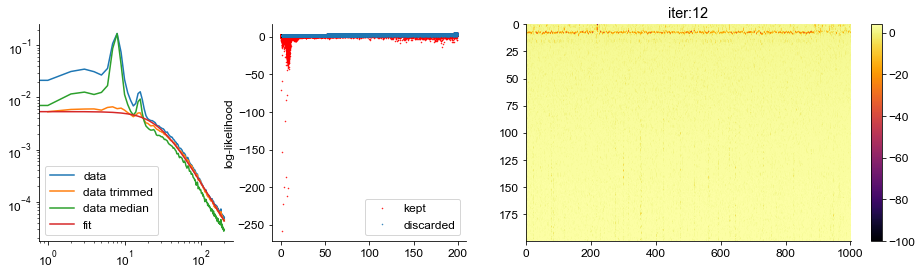

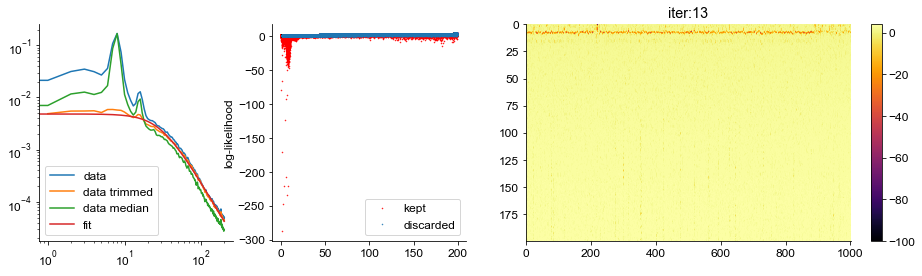

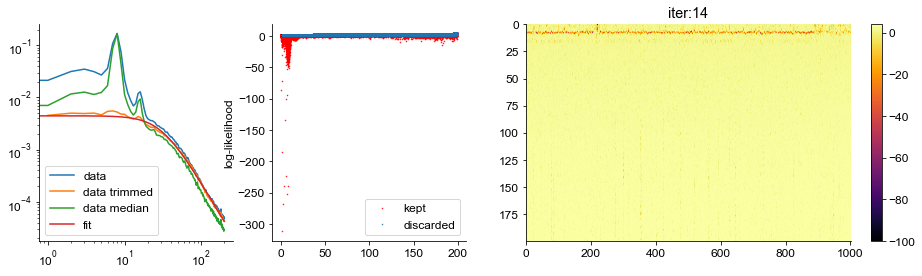

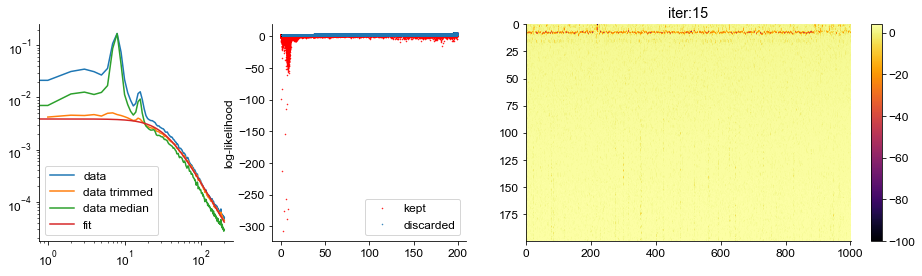

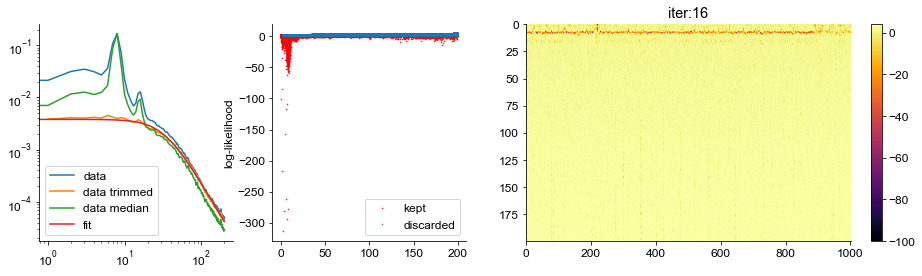

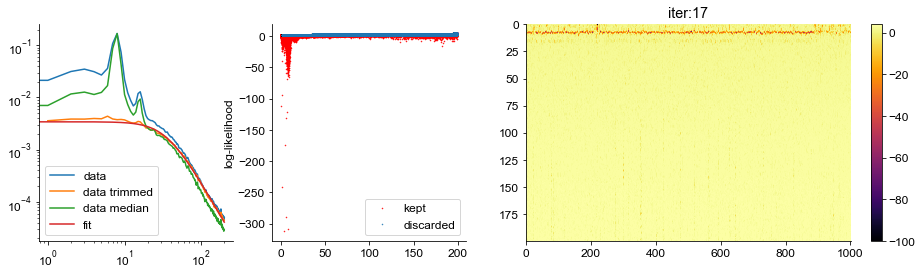

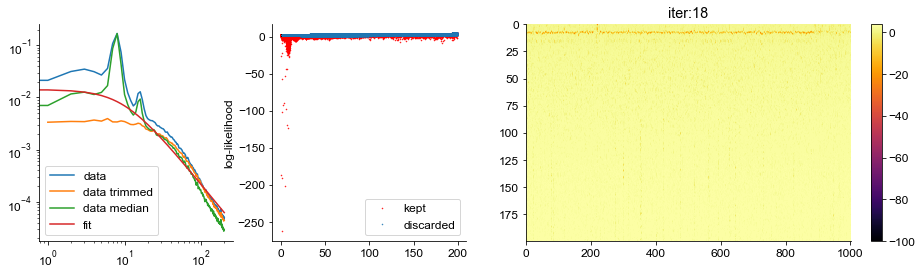

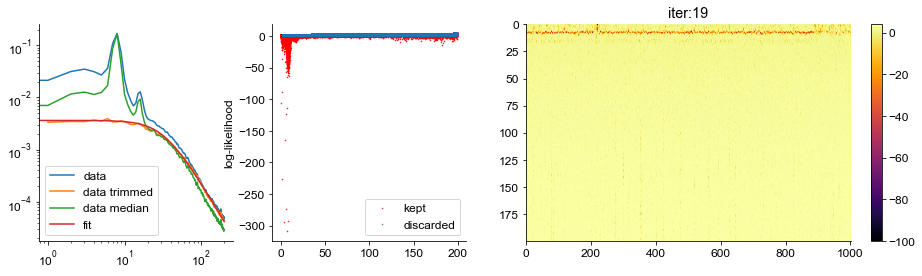

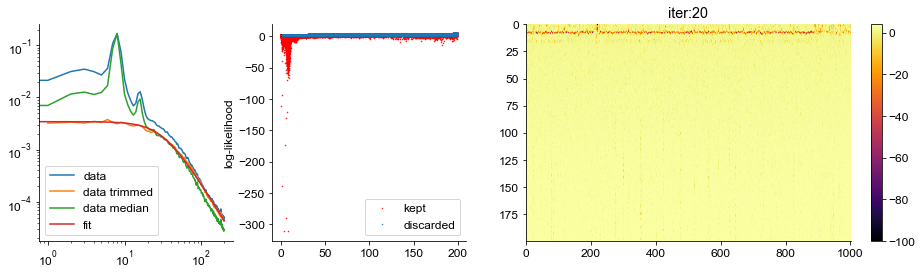

In [13]:
for i in range(20):
    # fit
    res = minimize(total_neglogL, x0, (df_select['freq'].values, df_select['power'].values), bounds=bounds)    
    print('%.2f percent data:'%(len(df_select)/len(df_spg)*100))
    print('offset: %.3f, knee: %.3f, exponent: %.3f'%(res.x[0],res.x[1],res.x[2]))
    
    psd_trim = df_select.groupby('freq').mean()['power']
    
    # compute point-wise log likelihood
    logL = compute_logL_flattened(res.x, df_spg['freq'], df_spg['power']).values
    print('mean trimmed logL: %.3f'%df_select['lh'].mean())
    print('---')
    
    
    # update
    df_spg['lh'] = np.nan
    df_spg.loc[:, 'lh'] = logL
    df_select.loc[:, 'lh'] = logL[df_select.index.values]

    # plot
    plt.figure(figsize=(16,4))
    
    # psds
    plt.subplot(1,4,1)
    plt.loglog(psd.index, psd, label='data')
    plt.loglog(psd_trim.index, psd_trim, label='data trimmed')
    plt.loglog(psd.index, psd_med, label='data median')
    A, k, exp = res.x
    plt.loglog(psd.index, lorentzian(psd.index, *res.x), label='fit')
    plt.legend()
    
    # plot likelihood
    plt.subplot(1,4,2)
    plt.plot(df_spg['freq'],df_spg['lh'], 'r.', ms=1, label='kept')
    plt.plot(df_select['freq'],df_select['lh'], '.', ms=1, label='discarded')
    plt.ylabel('log-likelihood');plt.legend()

    plt.subplot(1,2,2)
    plt.imshow(df_spg['lh'].values.reshape((len(psd),-1)),aspect='auto', vmin=-100)
    plt.title('iter:%i'%(i+1))
    plt.colorbar()

    # re-subselect
    df_select = df_select[df_select['lh'] > np.percentile(df_select['lh'],npct)]

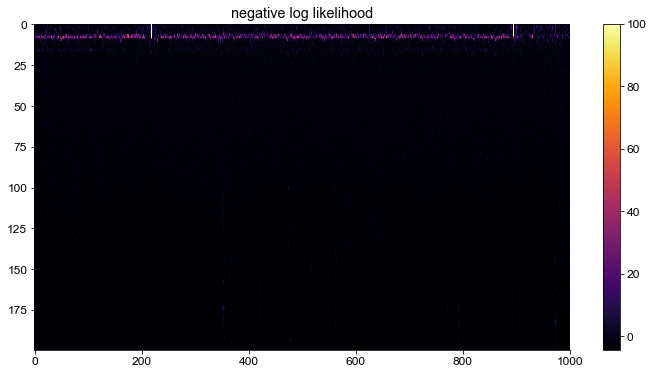

In [20]:
# see point-wise data negative log likelihood for the last fit
# brighter points are non-noise like
plt.figure(figsize=(12,6))
plt.imshow(-df_spg['lh'].values.reshape((len(psd),-1)),aspect='auto', vmax=100)
plt.title('negative log likelihood')
plt.colorbar()

# simulations

In [303]:
# Define the components of the combined signal to simulate
components = {'sim_synaptic_current' : {'n_neurons' : 1000, 'firing_rate' : 2, 't_ker' : 1.0,
                                         'tau_d' : 0.02},
              'sim_oscillation' : {'freq' : 8.2}}

sig = sim.sim_combined(n_seconds=180, fs=1000, components=components, component_variances=[1,0.4])
nperseg=1000
#f_stft, t_stft, stft = signal.stft(sig, fs=1000, window=np.ones(nperseg), nperseg=nperseg, noverlap=0, boundary=None, return_onesided=True)

# compute STFT
f_stft, t_stft, stft = signal.stft(sig, fs=1000, nperseg=nperseg, noverlap=0, boundary=None)

# # compute power and phase
# power, phase = compute_power_phase(stft)
power = abs(stft)**2

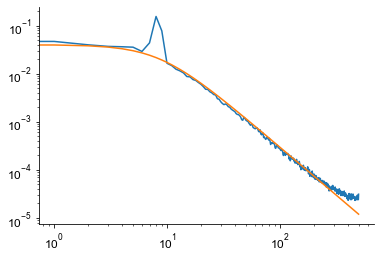

In [304]:
A, k, exp = 3, 75, 2
plt.loglog(np.mean(power,1))
plt.loglog(f_stft, lorentzian(f_stft, A, k, exp))

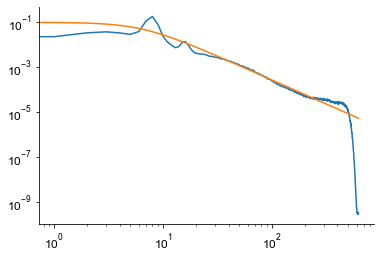

In [399]:
res = minimize(total_neglogL, (2, 50, 2), (f_stft[2:100], power[2:100]))
res.x
A, k, exp = res.x
plt.loglog(np.mean(power,1))
plt.loglog(f_stft, lorentzian(f_stft, A, k, exp))

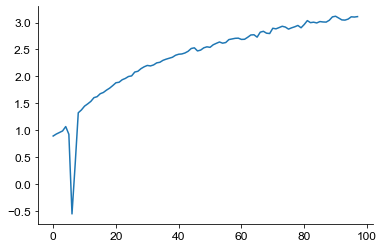

In [307]:
# plt.imshow(np.log10(power[:100]))
slogL = spectral_logL(res.x, f_stft[2:100], power[2:100])
# plt.imshow(slogL)
plt.plot(slogL.mean(1))